# GPGN409 homework 
your name: Benjamin Nguyen

In [1]:
include("cubePlot.jl")
using CSV, DataFrames
using GLMakie, ProgressMeter
using LinearAlgebra, LazyGrids
using Logging, Trapz
global_logger(ConsoleLogger(stderr, Logging.Error))
GLMakie.activate!(inline=true)

# Read the CSV file
df = CSV.File("Z_GR_NPHI_RHOB_CALI.txt",delim=',', ignorerepeated=true) |> DataFrame

# Convert columns to arrays
z = df[:, 1] .* 0.0003048  # Convert to kilometers
γ = df[:, 2]
ϕ = df[:, 3]
δ = df[:, 4]
cali = df[:, 5]
n = length(z);

# Define ranges for CALI, velocity, density, and porosity
# For plotting and the later PDF
cali_range = (5.9, 6.3) # CALI     min=5.9, max=6.3
v_x_range  = (3.0, 7.0) # Velocity min=3.0, max=7.0
δ_x_range  = (2.3, 2.8) # Density  min=2.3, max=2.8
ϕ_x_range  = (0.0, 0.3) # Porosity min=0.0, max=0.3
γ_x_range  = (0  , 200);# Gamma    min=0.0, max=200

**Prior dispersion**

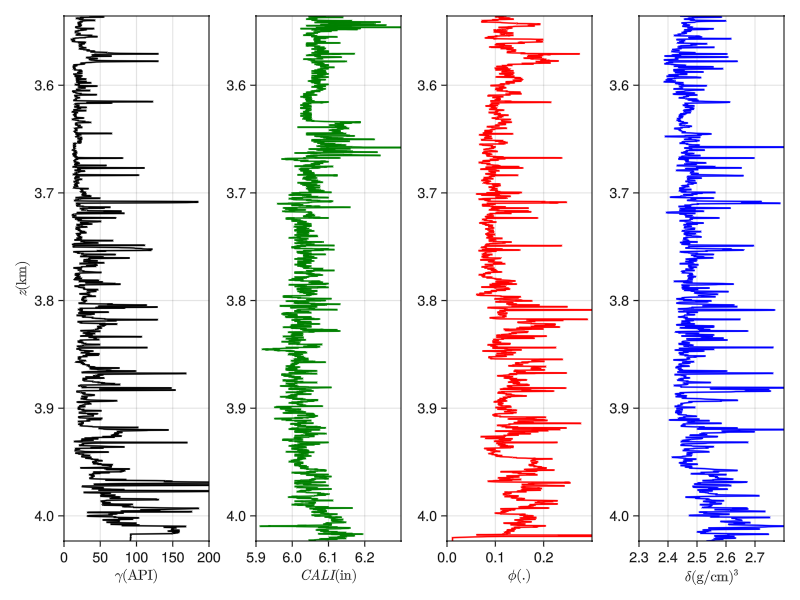

In [2]:
fig = Figure(size=(800, 600))

ax1 = Axis(fig[1, 1], xlabel=L"\gamma\text{(API)}", ylabel=L"z\text{(km)}", yreversed=true)
ax2 = Axis(fig[1, 2], xlabel=L"CALI\text{(in)}", yreversed=true)
ax3 = Axis(fig[1, 3], xlabel=L"\phi\text{(.)}", yreversed=true)
ax4 = Axis(fig[1, 4], xlabel=L"\delta\text{(g/cm)}^3", yreversed=true)
lines!(ax1, γ, z, color=:black)
xlims!(ax1, γ_x_range)
lines!(ax2, cali, z, color=:green)
xlims!(ax2, cali_range)
lines!(ax3, ϕ, z, color=:red)
xlims!(ax3, ϕ_x_range)
lines!(ax4, δ, z, color=:blue)
xlims!(ax4, δ_x_range)
linkyaxes!(ax1, ax2, ax3, ax4)
ylims!(ax4, maximum(z), minimum(z), )

fig

In [3]:
# Compute dispersion for delta and phi
cmax = 8  # Max allowed caliper
cref = 6  # Reference caliper
a_δ = 0.05  # Minimum uncertainty
a_ϕ = 0.03 # Minimum uncertainty
b_δ = range(0.04, stop=0.05, length=length(cali))
b_ϕ = range(0.05, stop=0.06, length=length(cali))

# Compute σ_δ, σ_ϕ and define σ_v
σ_δ = a_δ .+ (cali .- cref) ./ (cmax - cref) .* b_δ
σ_ϕ = a_ϕ .+ (cali .- cref) ./ (cmax - cref) .* b_ϕ
σ_v = 0.5

0.5

Here I add the dispersion using Gaussian function

The probability density function of a 1D Gaussian distribution is given by:
$$
g(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$
where the mean is denoted by $\mu$ and the variance by $\sigma^2$.


In [5]:
function gaussian_1d(σ, x, μ, n)
    # Replicate x to match n rows
    x_tiled = repeat(x', n, 1)  # Transpose x and repeat n times
    # Compute Gaussian function
    g = (1 ./ (σ .* sqrt(2 * π))) .* exp.(-0.5 * ((x_tiled .- μ) .^ 2) ./ (σ .^ 2))
    return g
end

# Define parameters
n_x = 100  # Number of values for dispersion

# Generate linearly spaced vectors
ϕ_x = range(ϕ_x_range..., length=n_x) |> collect;
v_x = range(v_x_range..., length=n_x) |> collect
δ_x = range(δ_x_range..., length=n_x) |> collect
v = 5.654 .- 0.008 .* γ # Compute v using the GR-v equation

# Define marginal PDFs using the gaussian_1d function
ϕ_marginal_prior = gaussian_1d(σ_ϕ, ϕ_x, ϕ, n);
v_marginal_prior = gaussian_1d(σ_v, v_x, v, n);
δ_marginal_prior = gaussian_1d(σ_δ, δ_x, δ, n);

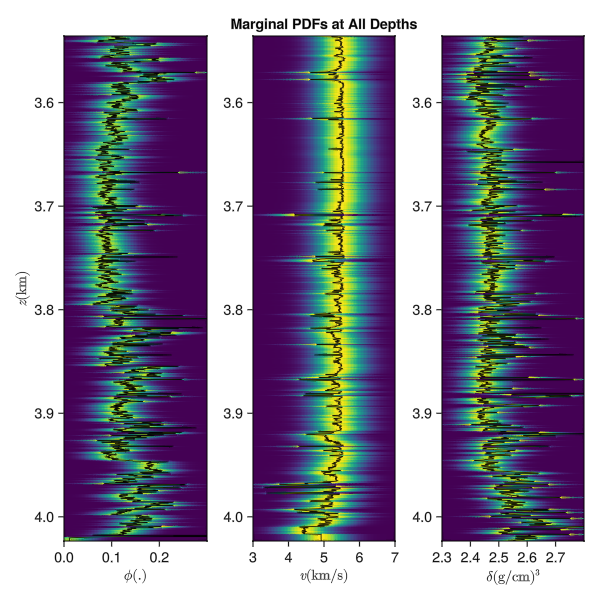

In [6]:
fig = Figure(size=(600, 600))
ax1 = Axis(fig[1, 1], xlabel=L"\phi\text{(.)}", yreversed=true, ylabel=L"z\text{(km)}")
ax2 = Axis(fig[1, 2], xlabel=L"v\text{(km/s)}", yreversed=true, title="Marginal PDFs at All Depths")
ax3 = Axis(fig[1, 3], xlabel=L"\delta\text{(g/cm)}^3", yreversed=true)
heatmap!(ax1, ϕ_x, z, ϕ_marginal_prior')
lines!(ax1, ϕ, z, color=:black, linewidth=0.75)
xlims!(ax1, ϕ_x_range)
heatmap!(ax2, v_x, z, v_marginal_prior')
lines!(ax2, v, z, color=:black, linewidth=0.75)
xlims!(ax2, v_x_range)
heatmap!(ax3, δ_x, z, δ_marginal_prior')
lines!(ax3, δ, z, color=:black, linewidth=0.75)
xlims!(ax3, δ_x_range)
linkyaxes!(ax1, ax2, ax3)
ylims!(ax3, maximum(z), minimum(z))
fig

I do the Bayesian inversion at the depth of 3.78 km.

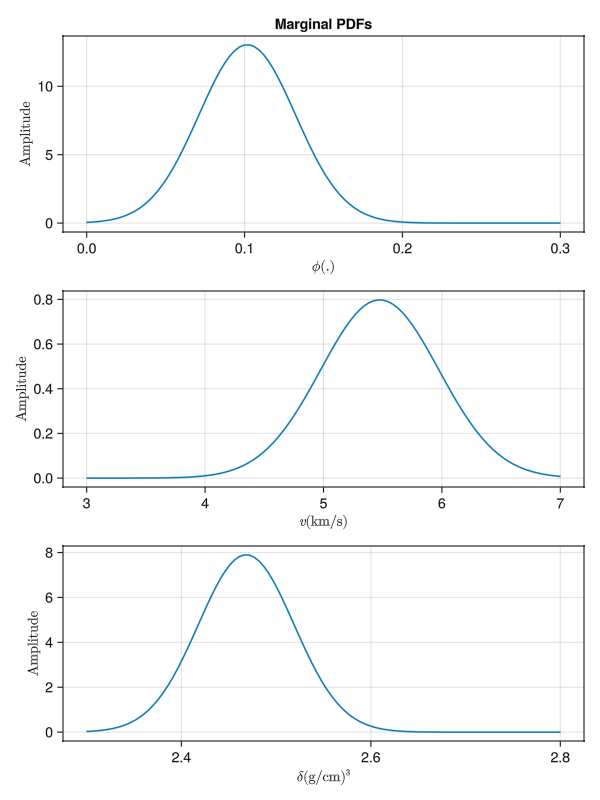

In [7]:
# Extract marginal PDFs for a specific index
index = 1600
δ_marginal_prior_onedepth = δ_marginal_prior[index, :]
v_marginal_prior_onedepth = v_marginal_prior[index, :]
ϕ_marginal_prior_onedepth = ϕ_marginal_prior[index, :]

fig = Figure(size=(600, 800))
ax1 = Axis(fig[1,1], xlabel=L"\phi\text{(.)}", ylabel=L"\text{Amplitude}", title="Marginal PDFs")
ax2 = Axis(fig[2,1], xlabel=L"v\text{(km/s)}", ylabel=L"\text{Amplitude}")
ax3 = Axis(fig[3,1], xlabel=L"\delta\text{(g/cm)}^3", ylabel=L"\text{Amplitude}")
lines!(ax1, ϕ_x, ϕ_marginal_prior_onedepth)
lines!(ax2, v_x, v_marginal_prior_onedepth)
lines!(ax3, δ_x, δ_marginal_prior_onedepth)
fig

In [8]:
# Create a 3D grid for joint PDF calculation
δ_grid, v_grid, ϕ_grid = ndgrid(δ_marginal_prior_onedepth,
                                v_marginal_prior_onedepth,
                                ϕ_marginal_prior_onedepth)

# # Calculate the joint PDF as the product of marginals
g_joint_prior = δ_grid .* v_grid .* ϕ_grid;

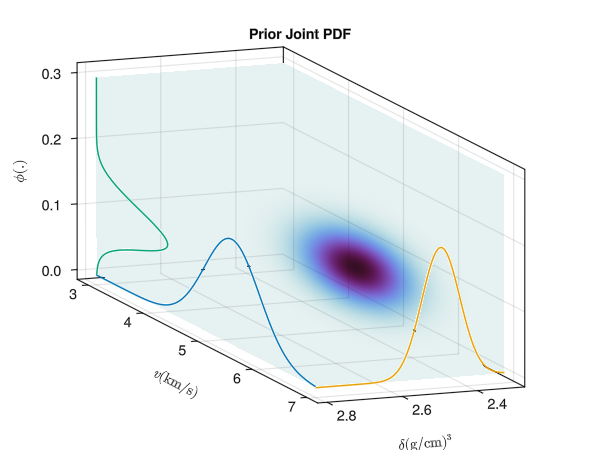

In [9]:
GLMakie.activate!(inline=true)

# Create the volume plot
fig, ax, _ = volume(
    δ_x, v_x, ϕ_x, g_joint_prior;
    colorrange = (minimum(g_joint_prior), maximum(g_joint_prior)),
    colormap = :dense,
    transparency = true,
    figure = (;),
    axis = (
        type = Axis3,
        # perspectiveness = 0.5,
        azimuth = 1.2,
        elevation = 0.2,
        aspect = (1, 3, 1),
        xlabel=L"\delta\text{(g/cm)}^3",
        ylabel=L"v\text{(km/s)}",
        zlabel=L"\phi\text{(.)}",
        title="Prior Joint PDF"
    )
)
lines!(ax,Point3f.(maximum(δ_x), v_x, v_marginal_prior_onedepth/5 .+minimum(ϕ_x)))
lines!(ax,Point3f.(δ_x, maximum(v_x), δ_marginal_prior_onedepth/40 .+minimum(ϕ_x)))
lines!(ax,Point3f.(maximum(δ_x), ϕ_marginal_prior_onedepth/10 .+minimum(v_x), ϕ_x))
fig


**Theory PDF**

Self-define the dispersion for the theoretical pdf by 2D Gaussian function.

The probability density function of a 2D Gaussian distribution is given by:
$$
g(x, y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1 - \rho^2}} \exp\left(-\frac{1}{2(1 - \rho^2)} \left( \frac{(x - \mu_x)^2}{\sigma_x^2} - \frac{2\rho(x - \mu_x)(y - \mu_y)}{\sigma_x \sigma_y} + \frac{(y - \mu_y)^2}{\sigma_y^2} \right) \right)
$$
where:
- $\mu_x$ and $\mu_y$ are the means for $x$ and $y$,
- $\sigma_x^2$ and $\sigma_y^2$ are the variances for $x$ and $y$,
- $\rho$ is the correlation coefficient between $x$ and $y$.


In [10]:
# Wyllie equation
δ_f, δ_m, v_f, v_m = 1.00, 2.71, 1.50, 6.64
ϕ_theory_x = ϕ_x
v_theory_x = @. 1/((1-ϕ_theory_x)/v_m+ϕ_theory_x/v_f)
δ_theory_x = @. (1-ϕ_theory_x)*δ_m + ϕ_theory_x*δ_f

# Define the 2D Gaussian function
function gaussian_2d(x, y, μ_x, μ_y, σ_x, σ_y)
    # Create meshgrid for velocity and density
    X, Y = ndgrid(x, y)
    # Calculate the Gaussian
    coeff = 1 / (2 * π * σ_x * σ_y)
    exponent = -((X .- μ_x).^2 / (2 * σ_x^2) + (Y .- μ_y).^2 / (2 * σ_y^2))
    # exponent = -((X .- μ_x).^2 / (2 * σ_x^2) + (Y .- μ_y).^2 / (2 * σ_y^2))
    g = coeff .* exp.(exponent)
    return g
end
# Parameters for σ_ϕ and σ_δ
σ_ϕ = 0.3
σ_δ = 0.04

g_joint_theory = zeros(n_x, n_x, n_x)
for i in 1:n_x
    g_joint_theory[:, :, i] .= gaussian_2d(δ_x, v_x, δ_theory_x[i], v_theory_x[i], σ_δ, σ_v)
end


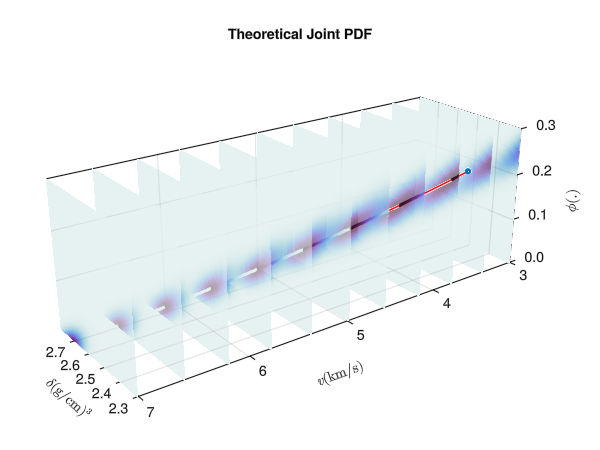

In [11]:
# Example usage

GLMakie.activate!(inline=true)


# Example usage
slice = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

GLMakie.activate!(inline=true) 
# GLMakie.activate!(inline=false)

fig = plot3D(δ_x, v_x, ϕ_x, g_joint_theory, slice;
                  direction="y",
                  lx=L"δ\text{(g/cm)}^3",
                  ly=L"v\text{(km/s)}",
                  lz=L"ϕ\text{(.)}",
                  aspect_ratio=(1, 3, 1), azimuth=2.5,
                  title="Theoretical Joint PDF")
lines!(δ_theory_x[1:end-20],v_theory_x[1:end-20], ϕ_theory_x[1:end-20], color=:red)
scatter!(δ_theory_x[end-20],v_theory_x[end-20], ϕ_theory_x[end-20])
fig

**Posterior Joint Function.**

I am more interested in the Marginal PDF of the model. Therefore, I will do the normalization at the end for the Marginal PDF

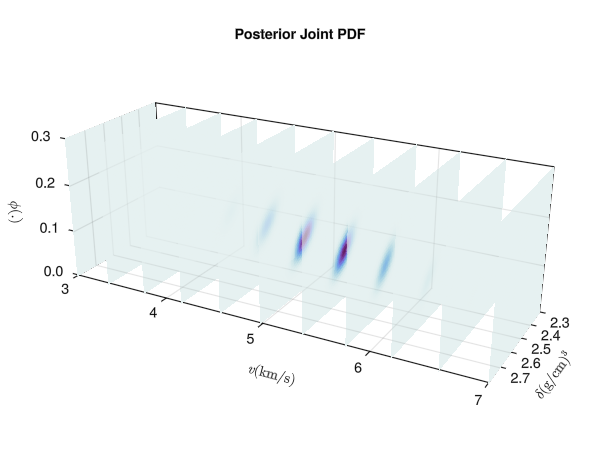

In [12]:
g_joint_post = @. g_joint_prior * g_joint_theory
GLMakie.activate!(inline=false)
GLMakie.activate!(inline=true)

fig = plot3D(δ_x, v_x, ϕ_x, g_joint_post, slice;
                  direction="y",
                  lx=L"δ\text{(g/cm)}^3",
                  ly=L"v\text{(km/s)}",
                  lz=L"ϕ\text{(.)}",
                  aspect_ratio=(1, 3, 1),azimuth=0.5,
                  title="Posterior Joint PDF")
fig

Comparision between the posterior velicity and prior velocity

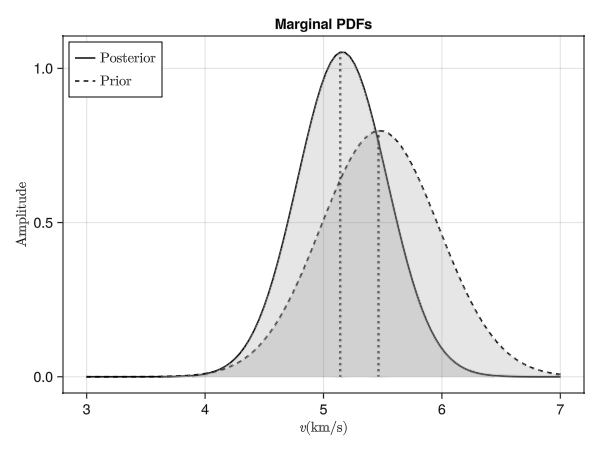

In [13]:
# Sum over the 1st and 3rd dimensions (equivalent to axis 0 and 2 in Python)
v_marginal_posterior = sum(g_joint_post, dims=(1, 3))[1, :]

# Normalize using trapezoidal integration
v_marginal_posterior /= trapz(v_x, v_marginal_posterior)

# Find the indices and values of the peaks

max_val_post, max_index_post = findmax(v_marginal_posterior)
max_val_prior, max_index_prior = findmax(v_marginal_prior_onedepth)

v_peak_post = v_x[max_index_post]
v_peak_prior = v_x[max_index_prior]

# Plot the result
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"v\text{(km/s)}", ylabel=L"\text{Amplitude}", title="Marginal PDFs")

# Plot the posterior and prior lines
lines!(ax, v_x, v_marginal_posterior, label=L"\text{Posterior}", color=:black)
band!(ax, v_x, 0*v_x, v_marginal_posterior, color=(:grey, 0.2), transparency=true)
lines!(ax, v_x, v_marginal_prior_onedepth, label=L"\text{Prior}", linestyle=:dash, color=:black)
band!(ax, v_x, 0*v_x, v_marginal_prior_onedepth, color=(:grey, 0.2), transparency=true)

# Add vertical lines from 0 to the peaks with black color and no label
lines!(ax, [v_peak_post, v_peak_post], [0, max_val_post], color=:black, linestyle=:dot, linewidth=2)
lines!(ax, [v_peak_prior, v_peak_prior], [0, max_val_prior], color=:black, linestyle=:dot, linewidth=2)

# Add legend to the axis
axislegend(ax, position=:lt)

fig


**Explain the observation**

The differences between the prior and posterior probability density functions highlight the impact of data on parameter estimation. The transition from a wider, flatter prior to a narrower, taller posterior illustrates how the observed data refines our understanding of the model parameters, leading to more confident estimates with increased probability for certain values.

In [14]:
# Define a function to posterior velocity at all depth

function calculate_velocity_posterior(n, δ_marginal_prior,
                        v_marginal_prior,
                        ϕ_marginal_prior,
                        δ_x, v_x,
                        δ_theory_x,
                        v_theory_x,
                        σ_δ, σ_v, n_x)
    v_marginal_matrix = []  # To collect all v_marginal_posterior vectors
    v_post = Float64[]  # To collect all v_peak_post values

    @showprogress for index = 1:n
    # Create 3D grids for δ, v, and ϕ priors
        δ_grid, v_grid, ϕ_grid = ndgrid(δ_marginal_prior[index, :],
            v_marginal_prior[index, :],
            ϕ_marginal_prior[index, :])
        g_joint_prior = δ_grid .* v_grid .* ϕ_grid

    # Initialize the joint theoretical grid
    g_joint_theory = zeros(size(g_joint_prior, 1), size(g_joint_prior, 2), n_x)

    # Calculate the theoretical joint distribution for each x
    for i in 1:n_x
        g_joint_theory[:, :, i] .= gaussian_2d(δ_x, v_x, δ_theory_x[i], v_theory_x[i], σ_δ, σ_v)
    end

    # Posterior joint distribution
    g_joint_post = @. g_joint_prior * g_joint_theory

    # Sum over the 1st and 3rd dimensions (equivalent to axis 0 and 2 in Python)
    v_marginal_posterior = sum(g_joint_post, dims=(1, 3))[1, :]

    # Normalize using trapezoidal integration
    v_marginal_posterior /= trapz(v_x, v_marginal_posterior)

    # Find the maximum value and corresponding index
    max_val_post, max_index_post = findmax(v_marginal_posterior)
    v_peak_post = v_x[max_index_post]

    # Append to v_marginal_matrix and v_post
    push!(v_marginal_matrix, v_marginal_posterior)
    push!(v_post, v_peak_post)
    end

    # Convert v_marginal_matrix to a matrix where each column is a posterior vector
    v_marginal_matrix = hcat(v_marginal_matrix...)

    return v_marginal_matrix, v_post
end;


In [15]:
# Compute posterior velocity at all depth
v_marginal_matrix_1, v_post_1 = calculate_velocity_posterior(n,
                                δ_marginal_prior,
                                v_marginal_prior,
                                ϕ_marginal_prior,
                                δ_x, v_x,
                                δ_theory_x,
                                v_theory_x,
                                σ_δ, σ_v, n_x);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


In [16]:
# Compute dispersion for delta and phi
cmax = 8  # Max allowed caliper
cref = 6  # Reference caliper
a_δ = 0.06  # Minimum uncertainty
a_ϕ = 0.05 # Minimum uncertainty
b_δ = range(0.04, stop=0.06, length=length(cali))
b_ϕ = range(0.05, stop=0.07, length=length(cali))

# Compute σ_δ, σ_ϕ and define σ_v
σ_δ = a_δ .+ (cali .- cref) ./ (cmax - cref) .* b_δ
σ_ϕ = a_ϕ .+ (cali .- cref) ./ (cmax - cref) .* b_ϕ
σ_v = 0.8

ϕ_marginal_prior = gaussian_1d(σ_ϕ, ϕ_x, ϕ, n);
v_marginal_prior = gaussian_1d(σ_v, v_x, v, n);
δ_marginal_prior = gaussian_1d(σ_δ, δ_x, δ, n);

# Parameters for σ_ϕ and σ_δ
σ_ϕ = 0.3
σ_δ = 0.04 #same dipsersionw with previos PDF

v_marginal_matrix_2, v_post_2 = calculate_velocity_posterior(n,
                                δ_marginal_prior,
                                v_marginal_prior,
                                ϕ_marginal_prior,
                                δ_x, v_x,
                                δ_theory_x,
                                v_theory_x,
                                σ_δ, σ_v, n_x);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


In [17]:
v_marginal_prior = v_marginal_matrix_2';
v_marginal_matrix_3, v_post_3 = calculate_velocity_posterior(n,
                                δ_marginal_prior,
                                v_marginal_prior,
                                ϕ_marginal_prior,
                                δ_x, v_x,
                                δ_theory_x,
                                v_theory_x,
                                σ_δ, σ_v, n_x);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


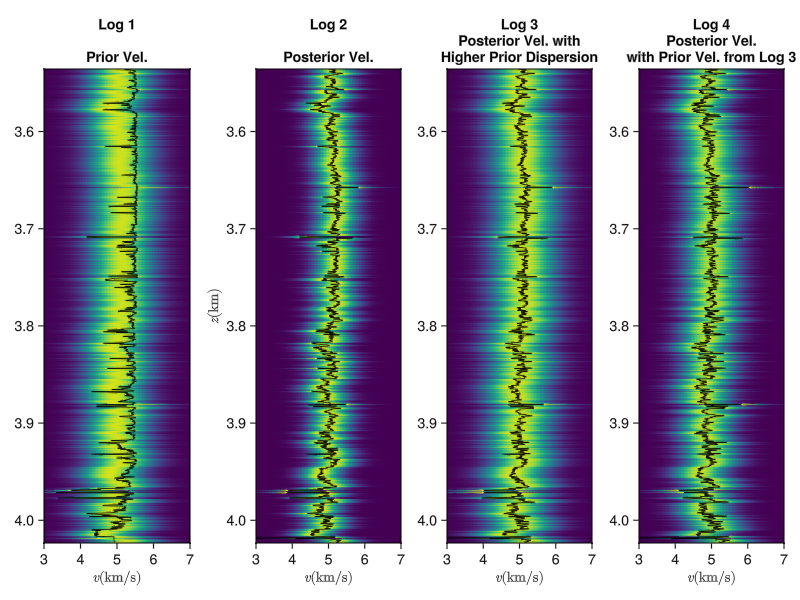

In [29]:
fig = Figure(size=(800, 600))

ax1 = Axis(fig[1, 1], xlabel=L"v\text{(km/s)}", yreversed=true,
            title="Log 1\n\nPrior Vel.")
ax2 = Axis(fig[1, 2], xlabel=L"v\text{(km/s)}",
            yreversed=true, ylabel=L"z\text{(km)}",
            title="Log 2\n\nPosterior Vel.")
ax3 = Axis(fig[1, 3], xlabel=L"v\text{(km/s)}", yreversed=true,
            title="Log 3\nPosterior Vel. with\nHigher Prior Dispersion")
ax4 = Axis(fig[1, 4], xlabel=L"v\text{(km/s)}", yreversed=true,
title="Log 4\nPosterior Vel.\nwith Prior Vel. from Log 3")
heatmap!(ax1, v_x, z, v_marginal_prior')
lines!(ax1, v, z, color=:black, linewidth=0.75)
xlims!(ax1, v_x_range)


heatmap!(ax2, v_x, z, v_marginal_matrix_1)
lines!(ax2, v_post_1, z, color=:black, linewidth=0.75)
xlims!(ax2, v_x_range)
heatmap!(ax3, v_x, z, v_marginal_matrix_2)
lines!(ax3, v_post_2, z, color=:black, linewidth=0.75)
xlims!(ax3, v_x_range)
heatmap!(ax4, v_x, z, v_marginal_matrix_3)
lines!(ax4, v_post_3, z, color=:black, linewidth=0.75)
xlims!(ax4, v_x_range)

linkyaxes!(ax1, ax2, ax3)
ylims!(ax3, maximum(z), minimum(z))
fig

- Log 1: Prior Velocity with High Dispersion

The prior velocity distribution is characterized by high dispersion, indicating a broad range of potential velocities without much certainty. This represents the initial state of the model before any Bayesian inversion is applied.

- Log 2: Posterior Velocity after Bayesian Inversion

After applying the Bayesian inversion, the dispersion in the posterior velocity is reduced compared to the prior in Log 1. The model has incorporated observed data or additional information, leading to a more focused estimate of velocity, demonstrating the effect of Bayesian updating.

- Log 3: Posterior Velocity with Higher Prior Dispersion

Here, the dispersion is higher in marginal prior models. As a result, the posterior velocity also shows increased dispersion compared to Log 2. This illustrates that when the initial prior is broader, the posterior distribution retains more uncertainty, reflecting the influence of the more uncertain prior.

- Log 4: Posterior Velocity with Prior from Log 3

In this scenario, it is assumed that more information about the velocity is available, so the prior used for this inversion is the posterior of Log 3. The posterior in Log 4 shows reduced dispersion compared to the prior in Log 3. This demonstrates the impact of incorporating additional information, which constrains the uncertainty even with a more uncertain initial prior.

